## Curve Number Hydrology
Demonstration use case of ipython notebook in exploring relationships of rainfall and watershed characteristics to runoff.
Modify input values in the appropriate boxes then press the run button above.

#### Enter base watershed characteristics below. 
######      Required
    prec = precip depth for storm in inches (req'd)
    cnum = curve number for soil and landcover type (req'd) 
    area = watershed area in acres (req'd)  
    slp = watershed slope (x/y) (req'd)
    pf = hydrograph peak factor (req'd)
######      Optional
    iabs = intial abstraction value, 0.05 or 0.2 most common, 0.2 is default (opt) 
    flen = flow path length, in feet, set to 0 if unknown will calculate using eq 630 15-5 (opt)

In [656]:
import numpy as np
from matplotlib import pyplot as plt

def resample(delta, xvals, yvals):
    """
    resamples a function of x and y values at a new delta x via linear
    interpolation
    """
    nu_x = np.zeros(1)
    nu_y = np.zeros(1)
    x = 0
    # interpolate out just a bit longer than the original distribution
    while x < xvals[-1]:
        x+=delta
        nu_x = np.append(nu_x, x)
        y = linterp(x, xvals, yvals)
        nu_y = np.append(nu_y, y)
    return nu_x, nu_y

def linterp(x, xvals, yvals):
    """
    Linearly interpotates the y value given a value x and 
    vectors of x and y for the function range.  xvals and yvals must be same 
    dimensions
    
    Inputs:
        x, (float) - known value of x for which corresponding unknown value
                    of y is needed
        xvals, (vector, floats) - vector of x-values for which corresponding 
                    y-values are known.
        yvals, (vector, floats) - vector of y-values for which corresponding
                    x- values are given.
    Outputs:
        y (float) - determined value of y corresponding to x
    """
    # test for dimensional consistency
    if xvals.shape == yvals.shape: 
        # make sure x is in the range of the function
        # check to see if this x value is explicit
        if x in xvals:
            i = np.where(xvals==x)[0][0]
            y = yvals[i]
        elif x >= xvals[-1]:
            y = yvals[-1] +\
                (yvals[-1]-yvals[-2])/(xvals[-1]-xvals[-2])*(x - xvals[-1])
        elif x <= xvals[0]:
            y = yvals[0]
        else:
            i = 0
            # get last xval just smaller than desired location    
            while x >= xvals[i] and i < xvals.shape[0]-1:
                i+=1
            emm = (yvals[i] - yvals[i-1])/(xvals[i] - xvals[i-1])
            y = yvals[i-1] + (x - xvals[i-1])*emm
    else:
        print("x and y ranges do not agree")
        y = 0
    return y


def calc_cn_runoff(cn, p, ini_rat=0.05):
    """
    Calculates total and incremental runoff for a given storm 
    """
    s = max(1000./cn - 10.,0)
    ia = s*ini_rat
    inc_ro = np.zeros(p.shape[0])
    tot_ro = np.zeros(p.shape[0])
    for i in range(p.shape[0]):
        if p[i] > ia:
            tot_ro[i] = ((p[i]-ia)**2/(p[i]+s-ia)) 
            inc_ro[i] = tot_ro[i] - tot_ro[i-1]
    return tot_ro, inc_ro


def calc_gamma(pf, inc,  tol=1e-7, min_pts=100):
    """
    calculates runoff hydrograph at an interval 
    m-vals across the range of 100-600 can be approximated
    using prf and the equation below. Relationship was constructed using
    table 630-16.5 from NEH
    
    Inputs:

    Outputs:

    """
    ## calculate m factor for this runoff peaking factor (ropf)
    m = round(1.46216e-5*pf**2+4.36124e-4*pf+6.7188e-2,2)
    
    i = 1
    q = tol+1
    t_rat = np.zeros(1)
    q_rat = np.zeros(1)
    
    while ((q_rat[i-1] > tol) or (i < min_pts)):
        t_rat =np.append(t_rat, t_rat[i-1]+inc)
        q = np.exp(m)*t_rat[i]**m*np.exp((-m*t_rat[i]))
        if q > tol:
            q_rat = np.append(q_rat, q)
        else:
            q_rat = np.append(q_rat, 0)
        i+=1
    return t_rat, q_rat


def make_hydro(inc_ro, uh_q):
    """
    creates a runoff hydrograph given a incremental runoff and 
    a unit hydrograph. Time intervals for both inputs must agree.
    
    """
    ## now need to 
    # reverse sort incremental runoff
    
    ## x is the runoff excess from the design storm hyetograph and 
    ## curve number 
    
    ## y is unit runoff hydrograph using the design hydrograph and watershed
    ## attributes
    
    ## reversed incremental runoff matrix has m rows, 2 times the length
    ## of the incremental runoff vector
    
    
    ## reversed incremental runoff matrix has n rows, the max of the length
    ## of the incremental runoff or the hydrograph vectors
    ## take longest vector and make the other one same length padding
    ## 0's on the end
    if inc_ro.shape[0] > uh_q.shape[0]:
        n = inc_ro.shape[0]
        q = np.zeros(n)
        q[0:uh_q.shape[0]] = uh_q
        ro = inc_ro
    else:
        n = uh_q.shape[0]
        ro = np.zeros(n)
        ro[0:inc_ro.shape[0]] = inc_ro
        q = uh_q
    m= 2*ro.shape[0]-1    
    ro_mat = np.zeros((m,n))
    ro = ro[::-1]

    for i in range(m):
        if i < n:
            ro_mat[i,0:i+1] = ro[n-i-1:n]
        else:
            ro_mat[i, i-n+1:] = ro[0:m-i]

    
    q = np.matmul(ro_mat,q)    
    return q


def calc_tc(a, y, cn, l):
    """
    calculates tc, tl based on MN guidance
    https://www.nrcs.usda.gov/Internet/FSE_DOCUMENTS/stelprdb1270339.pdf
    Inputs:
        a , float- area of watershed in acres
        y , float- slope of watershed in ft/ft
        cn - curve number for watershe
        l - flowpath length in feet
    
    Outputs:
        tc, float- time of concentration in hrs
    
    """
    # find storage of watershed (in) 
    # NEH630 Ch10 Eqn 10-12
    s = 1000.0/cn-10.0  
    
    # convert slope to pct
    y=y * 100.0
  
    # NEH630 Ch15 Eqn 15-4b
    tc = (l**0.8*(s+1.)**0.7)/(1140.*y**0.5) 

    tc = round(tc, 1)            
    return tc

def main(p, cn, a, s, pf, ia=0.2, fl=0):
    # conversion factor ac to sqmi
    ac2mi = 1.0/640

    #MSE3 24hr dist
    p_dist = np.array([0.0, 0.0, 0.001, 0.001, 0.001, 0.002, 0.002, 0.002, 0.003, 0.003, 0.004, 0.004, 0.005, 0.005, 0.006, 0.006, 
              0.007, 0.007, 0.008, 0.009, 0.009, 0.01, 0.01, 0.011, 0.012, 0.013, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 
              0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03, 0.032, 0.033, 0.034, 
              0.035, 0.036, 0.038, 0.039, 0.04, 0.041, 0.043, 0.044, 0.045, 0.047, 0.048, 0.05, 0.051, 0.052, 0.054, 0.055, 
              0.057, 0.058, 0.06, 0.062, 0.063, 0.065, 0.066, 0.068, 0.07, 0.071, 0.073, 0.075, 0.077, 0.078, 0.08, 0.082, 
              0.084, 0.086, 0.087, 0.089, 0.091, 0.093, 0.095, 0.097, 0.099, 0.101, 0.103, 0.106, 0.11, 0.113, 0.116, 0.12, 
              0.123, 0.127, 0.13, 0.134, 0.138, 0.141, 0.145, 0.149, 0.153, 0.156, 0.162, 0.169, 0.176, 0.184, 0.192, 0.202, 
              0.212, 0.223, 0.235, 0.248, 0.266, 0.291, 0.325, 0.373, 0.463, 0.628, 0.676, 0.709, 0.734, 0.752, 0.765, 0.777, 
              0.788, 0.798, 0.808, 0.816, 0.824, 0.831, 0.838, 0.844, 0.847, 0.851, 0.855, 0.859, 0.862, 0.866, 0.87, 0.873, 
              0.877, 0.88, 0.884, 0.887, 0.89, 0.894, 0.897, 0.899, 0.901, 0.903, 0.905, 0.907, 0.909, 0.911, 0.913, 0.914, 
              0.916, 0.918, 0.92, 0.922, 0.923, 0.925, 0.927, 0.929, 0.93, 0.932, 0.934, 0.935, 0.937, 0.938, 0.94, 0.942, 
              0.943, 0.945, 0.946, 0.948, 0.949, 0.95, 0.952, 0.953, 0.955, 0.956, 0.957, 0.959, 0.96, 0.961, 0.962, 0.964, 
              0.965, 0.966, 0.967, 0.968, 0.97, 0.971, 0.972, 0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.979, 0.98, 0.981, 
              0.982, 0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.987, 0.988, 0.989, 0.99, 0.99, 0.991, 0.991, 0.992, 0.993, 
              0.993, 0.994, 0.994, 0.995, 0.995, 0.996, 0.996, 0.997, 0.997, 0.998, 0.998, 0.998, 0.999, 0.999, 0.999, 1.0, 1.0])
    
    # default dt for MSE distro
    dt = 0.1
    
    # make vector of corresponding times for 24 hour distro
    t_dist = []
    for i in range(0,p_dist.shape[0]):
        t_dist.append(dt*i)
    t_dist = np.array(t_dist)

    # if flowlength not specified compute it based on area
    if fl <= 0.1:
        # eq 630 15-5
        fl = round(209*a**0.6,0)

    # calculate time of concentration
    Tc = calc_tc(a, s, cn, fl)

    # calculate delta D for further computations.
    #16A–13
    delD = 0.133*Tc 
    
    if delD > 0.1:
        delD = round(delD, 1)
    else:
        delD = round(delD, 1)
    
    ## NEED TO VERIFY THIS!!!!
    delT = delD
    if delT == "":
        delT = delD
    
    ## resample precip distro to delD interval
    px, py = resample(delT, t_dist, p_dist)
    
    prec = py*p
    time = px
    ## calculate incremental runoff for the storm at delD intervals
    tot_ro, inc_ro = calc_cn_runoff(cn, prec, ini_rat=ia)
    
    ## house cleaning
    del p_dist, px, py
    
    ## determine hydrograph that is being used and resample
    ## compute with gamma f(x)
    # calculate the duh for the number of points and time increment 
    duh_t, duh_q = calc_gamma(pf, 0.1)

    ## calculation unit hydrograph parameters
    #Eq 630-16A7
    Tp = round(delD/2 + 0.6*Tc,1) 
    #Eq 630-16A6
    Qp = round(pf*(a*ac2mi)*1.0/Tp,1) 

    uh_q = duh_q*Qp
    uh_t = duh_t*Tp
    ## resample the unit hydrographs to delD time step
    uh_t, uh_q = resample(delT, uh_t, uh_q)

    # check the volume under the unit hydro to make sure it agrees with geometry
    u_ro = 645.33*a*ac2mi*1.0
    if abs(uh_q.sum()*delT - u_ro)/u_ro < 0.02:
        q_in = make_hydro(inc_ro, uh_q)
        ## should check in_hydro volume
    else:
        print('unit hydrograph volume descrepancy too large to continue')
        q_in = uh_q * 0.0 
    
    return Tp, Qp, time, prec, tot_ro, inc_ro, q_in 

In [657]:
## required parameters
pr = 4.5
cnum = 88
area = 50
slp = 0.002
pf = 400

## optional parameters
iabs = 0.2
flen = 0

In [658]:
t_peak, q_peak, time, prec, tot_roff, inc_roff, q_in = main(pr, cnum, area, slp, pf, ia=iabs, fl=flen )

#### This is the rainfall distribution for the specified storm depth

total precipitation: 4.5 in, max precip intensity 28.1 in/hr


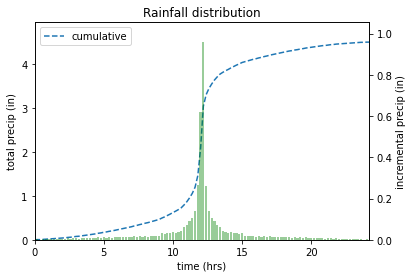

In [659]:
dt = 0.8* time[1]-time[0]
al = 0.4
p_bar = "g"
r_bar = "b"
## make a container for incremental precip vector
inc_prec = [prec[0]-prec[1]]
for i in range(1, prec.shape[0]):
    inc_prec.append(prec[i]-prec[i-1])
inc_prec=np.array(inc_prec)

## plot rainfall
fig, ax = plt.subplots()
ax.plot(time, prec, "--")
ax2 = ax.twinx()
ax2.bar(time, inc_prec, color=p_bar, alpha=al, width=dt)
ax2.set_ylim([0,inc_prec.max()+0.1*inc_prec.max()])
ax2.set_ylabel("incremental precip (in)")

ax.legend(["cumulative", "incremental"])
ax.set_title("Rainfall distribution")
ax.set_xlabel("time (hrs)")
ax.set_ylabel("total precip (in)")
ax.set_ylim([0,prec.max()+0.1*prec.max()])
ax.set_xlim([0, time[-1]])
max_i = prec.max()/dt

print("total precipitation: {0} in, max precip intensity {1:0.1f} in/hr".format(prec[-1], max_i))

#### This is the runoff distribution of the storm event

Total Runoff 3.2 in, max incremental runoff 0.8 in


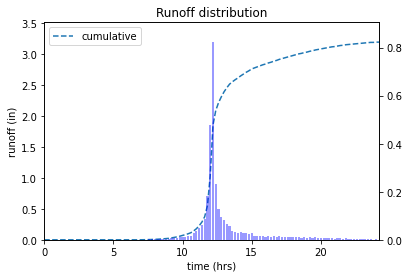

In [660]:
fig, ax = plt.subplots()
ax.plot(time, tot_roff, "--")
ax2 = ax.twinx()
ax2.bar(time, inc_roff, color=r_bar, alpha=al, width=dt)
ax2.set_ylim([0,inc_roff.max()+0.1*inc_roff.max()])
ax2.set_ylim([0,inc_roff.max()+0.1*inc_roff.max()])

ax.legend(["cumulative", "incremental"])
ax.set_title("Runoff distribution")
ax.set_xlabel("time (hrs)")
ax.set_ylabel("runoff (in)")
ax.set_ylim([0,tot_roff.max()+0.1*tot_roff.max()])
ax.set_xlim([0,time[-1]])
print("Total Runoff {0:0.1f} in, max incremental runoff {1:0.1f} in".format(tot_roff.max(),inc_roff.max()))

#### Plot the Runoff Hydrograph

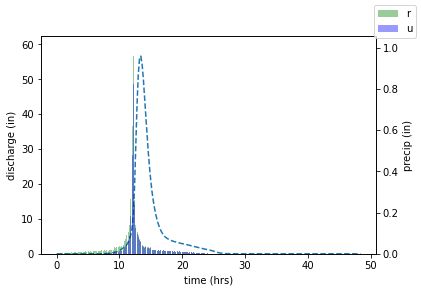

In [661]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.bar(time, inc_prec, color=p_bar, alpha=al, width=dt)
ax2.set_ylabel("precip (in)")
ax2.set_ylim([0,inc_prec.max()+0.1*inc_prec.max()])

ax2.bar(time, inc_roff, color=r_bar, alpha=al, width=dt)
## make sure both vectors have same dimensions
dt = time[1]-time[0]
q_time = time[:]
while q_time.shape[0] < q_in.shape[0]:
    q_time = np.append(q_time, q_time[-1]+dt)
fig.legend("runoff hydrograph")    
ax.plot(q_time, q_in, "--")
ax.set_xlabel("time (hrs)")
ax.set_ylabel("discharge (in)")
ax.set_ylim([0,q_in.max()+0.1*q_in.max()])
print("")

#### How does precip amount affect the runoff hydrograph?
Enter up to 5 precip depths between 1 and 10 inches into test in the code box below.  
Precip depths must be enclosed in square brackets and separated by commas.

In [662]:
precip_depths = [1,2,3,4,10]

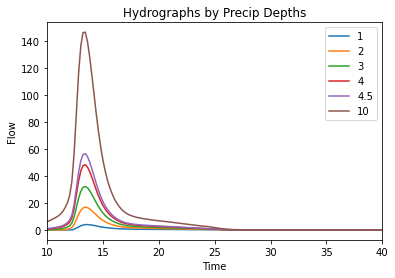

In [663]:
## edit here #############################################################
fig_title = 'Hydrographs by Precip Depths'
v_arr = precip_depths.copy()
v_min = 1
v_max = 10
v_old = pr
## Don't edit here #############################################################

## verify the input data
v_arr = v_arr[0:6]
if v_old not in v_arr:
    v_arr.append(v_old)
v_arr.sort()


for v in v_arr:
    if type(v) == "string":
        curve_numbers.remove(v)
    elif v<v_min or v>v_max:
        curve_numbers.remove(v)

dat = {}

fig, ax = plt.subplots()
for v in v_arr:
    this_v ={}
    ## Edit variable we're testing ######################################################################
    t_peak, q_peak, time, precip, tot_roff, inc_roff, q_in = main(v, cnum, area, slp, pf, ia=iabs, fl=flen )
    #####################################################################################################
    ## make sure both vectors have same dimensions
    dt = time[1]-time[0]
    q_time = time[:]
    while q_time.shape[0] < q_in.shape[0]:
        q_time = np.append(q_time, q_time[-1]+dt)
        
    this_v["t_peak"]=t_peak
    this_v["q_peak"]=q_peak
    this_v["t"] = q_time
    this_v["q"] = q_in
    dat[v]=this_v

## debug code to print 
deb = 0
if deb > 0:
    print("\nprf\tpeak_runoff\ttot_runoff")
for v in dat.keys():
    ax.plot(dat[v]["t"], dat[v]['q'])
    if deb > 0:
        print("{0}\t{1:0.1f}\t{2:0.1f}".format(v,dat[v]['q'].max(),dat[v]['q'].sum()))
ax.set_xlim([10,40])
ax.legend(dat.keys())
ax.set_xlabel("Time")
ax.set_ylabel("Flow")
ax.set_title(fig_title)

print("")



#### How does curve number affect the runoff hydrograph?
Enter up to 5 curve numbers between 40 and 100 into test in the code box below.  
Curve numbers must be enclosed in square brackets and separated by commas.

In [664]:
curve_numbers = [40, 50, 70, 80, 95]

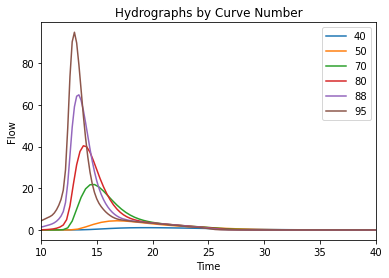

In [665]:
## edit here #############################################################
fig_title = 'Hydrographs by Curve Number'
v_arr = curve_numbers.copy()
v_min = 35
v_max = 100
v_old = cnum
## Don't edit here #############################################################

## verify the input data
v_arr = v_arr[0:6]
if v_old not in v_arr:
    v_arr.append(v_old)
v_arr.sort()


for v in v_arr:
    if type(v) == "string":
        curve_numbers.remove(v)
    elif v<v_min or v>v_max:
        curve_numbers.remove(v)

dat = {}

fig, ax = plt.subplots()
for v in v_arr:
    this_v ={}
    ## Edit variable we're testing ######################################################################
    t_peak, q_peak, time, precip, tot_roff, inc_roff, q_in = main(pd, v, area, slp, pf, ia=iabs, fl=flen )
    #####################################################################################################
    ## make sure both vectors have same dimensions
    dt = time[1]-time[0]
    q_time = time[:]
    while q_time.shape[0] < q_in.shape[0]:
        q_time = np.append(q_time, q_time[-1]+dt)
        
    this_v["t_peak"]=t_peak
    this_v["q_peak"]=q_peak
    this_v["t"] = q_time
    this_v["q"] = q_in
    dat[v]=this_v

## debug code to print 
deb = 0
if deb > 0:
    print("\nprf\tpeak_runoff\ttot_runoff")
for v in dat.keys():
    ax.plot(dat[v]["t"], dat[v]['q'])
    if deb > 0:
        print("{0}\t{1:0.1f}\t{2:0.1f}".format(v,dat[v]['q'].max(),dat[v]['q'].sum()))
ax.set_xlim([10,40])
ax.legend(dat.keys())
ax.set_xlabel("Time")
ax.set_ylabel("Flow")
ax.set_title(fig_title)

print("")


#### How does watershed area affect the runoff hydrograph?
Enter up to 5 areas between 5 and 200 acres into test in the code box below.  
Area must be enclosed in square brackets and separated by commas.

In [666]:
watershed_areas = [5, 10, 25, 100, 200]

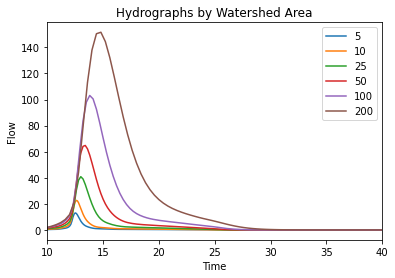

In [667]:
## edit here #############################################################
fig_title = 'Hydrographs by Watershed Area'
v_arr = watershed_areas.copy()
v_min = 5
v_max = 200
v_old = area
## Don't edit here #############################################################

## verify the input data
v_arr = v_arr[0:6]
if v_old not in v_arr:
    v_arr.append(v_old)
v_arr.sort()


for v in v_arr:
    if type(v) == "string":
        curve_numbers.remove(v)
    elif v<v_min or v>v_max:
        curve_numbers.remove(v)

dat = {}

fig, ax = plt.subplots()
for v in v_arr:
    this_v ={}
    ## Edit variable we're testing ######################################################################
    t_peak, q_peak, time, precip, tot_roff, inc_roff, q_in = main(pd, cnum, v, slp, pf, ia=iabs, fl=flen )
    #####################################################################################################
    ## make sure both vectors have same dimensions
    dt = time[1]-time[0]
    q_time = time[:]
    while q_time.shape[0] < q_in.shape[0]:
        q_time = np.append(q_time, q_time[-1]+dt)
        
    this_v["t_peak"]=t_peak
    this_v["q_peak"]=q_peak
    this_v["t"] = q_time
    this_v["q"] = q_in
    dat[v]=this_v

## debug code to print 
deb = 0
if deb > 0:
    print("\nprf\tpeak_runoff\ttot_runoff")
for v in dat.keys():
    ax.plot(dat[v]["t"], dat[v]['q'])
    if deb > 0:
        print("{0}\t{1:0.1f}\t{2:0.1f}".format(v,dat[v]['q'].max(),dat[v]['q'].sum()))
ax.set_xlim([10,40])
ax.legend(dat.keys())
ax.set_xlabel("Time")
ax.set_ylabel("Flow")
ax.set_title(fig_title)

print("")


#### How does watershed slope affect the runoff hydrograph?
Enter up to 5 slopes between 0.001 and 0.05 into test in the code box below.
Slopes must be enclosed in square brackets and separated by commas.

In [668]:
watershed_slopes = [0.001, 0.005, 0.01, 0.02, 0.03]

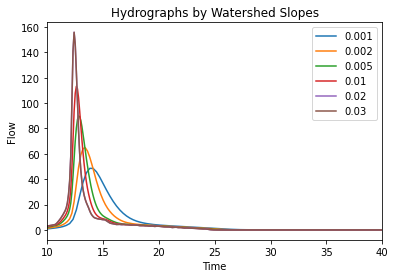

In [669]:
## edit here #############################################################
fig_title = 'Hydrographs by Watershed Slopes'
v_arr = watershed_slopes.copy()
v_min = 0.001
v_max = 0.05
v_old = slp
## Don't edit here #############################################################

## verify the input data
v_arr = v_arr[0:6]
if v_old not in v_arr:
    v_arr.append(v_old)
v_arr.sort()


for v in v_arr:
    if type(v) == "string":
        curve_numbers.remove(v)
    elif v<v_min or v>v_max:
        curve_numbers.remove(v)

dat = {}

fig, ax = plt.subplots()
for v in v_arr:
    this_v ={}
    ## Edit variable we're testing ######################################################################
    t_peak, q_peak, time, precip, tot_roff, inc_roff, q_in = main(pd, cnum, area, v, pf, ia=iabs, fl=flen )
    #####################################################################################################
    ## make sure both vectors have same dimensions
    dt = time[1]-time[0]
    q_time = time[:]
    while q_time.shape[0] < q_in.shape[0]:
        q_time = np.append(q_time, q_time[-1]+dt)
        
    this_v["t_peak"]=t_peak
    this_v["q_peak"]=q_peak
    this_v["t"] = q_time
    this_v["q"] = q_in
    dat[v]=this_v

## debug code to print 
deb = 0
if deb > 0:
    print("\nprf\tpeak_runoff\ttot_runoff")
for v in dat.keys():
    ax.plot(dat[v]["t"], dat[v]['q'])
    if deb > 0:
        print("{0}\t{1:0.1f}\t{2:0.1f}".format(v,dat[v]['q'].max(),dat[v]['q'].sum()))
ax.set_xlim([10,40])
ax.legend(dat.keys())
ax.set_xlabel("Time")
ax.set_ylabel("Flow")
ax.set_title(fig_title)

print("")


#### How does initial abstraction affect the runoff hydrograph?
Enter up to 5 initial abstraction coefficients between 0.01 and 0.5 into test in the code box below.
Coefficients must be enclosed in square brackets and separated by commas.

In [670]:
init_abs = [0.05, 0.1, 0.3, 0.4, 0.5]

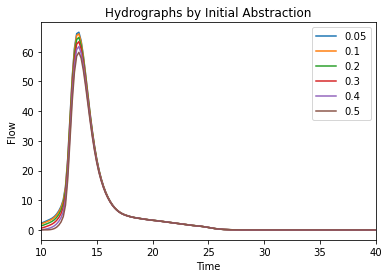

In [671]:
## edit here #############################################################
fig_title = 'Hydrographs by Initial Abstraction'
v_arr = init_abs.copy()
v_min = 0.01
v_max = 0.5
v_old = iabs
## Don't edit here #############################################################

## verify the input data
v_arr = v_arr[0:6]
if v_old not in v_arr:
    v_arr.append(v_old)
v_arr.sort()


for v in v_arr:
    if type(v) == "string":
        curve_numbers.remove(v)
    elif v<v_min or v>v_max:
        curve_numbers.remove(v)

dat = {}

fig, ax = plt.subplots()
for v in v_arr:
    this_v ={}
    ## Edit variable we're testing ######################################################################
    t_peak, q_peak, time, precip, tot_roff, inc_roff, q_in = main(pd, cnum, area, slp, pf, ia=v, fl=flen )
    #####################################################################################################
    ## make sure both vectors have same dimensions
    dt = time[1]-time[0]
    q_time = time[:]
    while q_time.shape[0] < q_in.shape[0]:
        q_time = np.append(q_time, q_time[-1]+dt)
        
    this_v["t_peak"]=t_peak
    this_v["q_peak"]=q_peak
    this_v["t"] = q_time
    this_v["q"] = q_in
    dat[v]=this_v

## debug code to print 
deb = 0
if deb > 0:
    print("\nprf\tpeak_runoff\ttot_runoff")
for v in dat.keys():
    ax.plot(dat[v]["t"], dat[v]['q'])
    if deb > 0:
        print("{0}\t{1:0.1f}\t{2:0.1f}".format(v,dat[v]['q'].max(),dat[v]['q'].sum()))
ax.set_xlim([10,40])
ax.legend(dat.keys())
ax.set_xlabel("Time")
ax.set_ylabel("Flow")
ax.set_title(fig_title)

print("")


#### How do peak rate factors affect the runoff hydrograph?
Enter up to 5 between 100 and 800 peak rate factors to test in the code box below.
Peak factor values must be enclosed in square brackets and separated by commas. 

In [672]:
peak_rate_factors = [300,375,425,475,600]

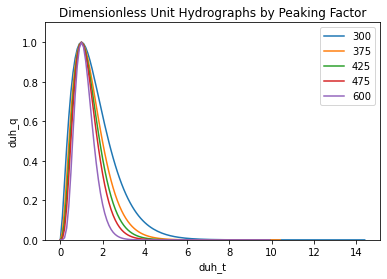

In [673]:
fig, ax = plt.subplots()
for p in peak_rate_factors:
    duh_t, duh_q = calc_gamma(p, 0.1)
    ax.plot(duh_t,duh_q, "-")
    ax.legend(peak_rate_factors)
    ax.set_title('Dimensionless Unit Hydrographs by Peaking Factor')
    ax.set_xlabel("duh_t")
    ax.set_ylabel("duh_q")
    ax.set_ylim([0,1.1*duh_q.max()])

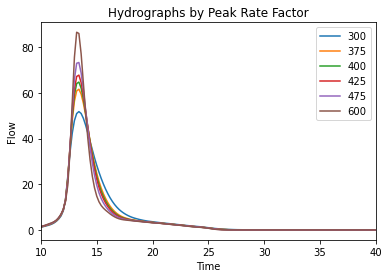

In [674]:
## edit here #############################################################
fig_title = 'Hydrographs by Peak Rate Factor'
v_arr = peak_rate_factors.copy()
v_min = 100
v_max = 800
v_old = pf
## Don't edit here #############################################################

## verify the input data
v_arr = v_arr[0:6]
if v_old not in v_arr:
    v_arr.append(v_old)
v_arr.sort()


for v in v_arr:
    if type(v) == "string":
        curve_numbers.remove(v)
    elif v<v_min or v>v_max:
        curve_numbers.remove(v)

dat = {}

fig, ax = plt.subplots()
for v in v_arr:
    this_v ={}
    ## Edit variable we're testing ######################################################################
    t_peak, q_peak, time, precip, tot_roff, inc_roff, q_in = main(pd, cnum, area, slp, v, ia=iabs, fl=flen )
    #####################################################################################################
    ## make sure both vectors have same dimensions
    dt = time[1]-time[0]
    q_time = time[:]
    while q_time.shape[0] < q_in.shape[0]:
        q_time = np.append(q_time, q_time[-1]+dt)
        
    this_v["t_peak"]=t_peak
    this_v["q_peak"]=q_peak
    this_v["t"] = q_time
    this_v["q"] = q_in
    dat[v]=this_v

## debug code to print 
deb = 0
if deb > 0:
    print("\nprf\tpeak_runoff\ttot_runoff")
for v in dat.keys():
    ax.plot(dat[v]["t"], dat[v]['q'])
    if deb > 0:
        print("{0}\t{1:0.1f}\t{2:0.1f}".format(v,dat[v]['q'].max(),dat[v]['q'].sum()))
ax.set_xlim([10,40])
ax.legend(dat.keys())
ax.set_xlabel("Time")
ax.set_ylabel("Flow")
ax.set_title(fig_title)

print("")